In [254]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cmath

#physical constants
au_cm_1 = 8065.54429*27.211385
au_eV = 27.211385
au_aa = 0.52917721092
au_1amu = 1836.15267389

Morse potential :

$V(r) = D_e (1-e^{a(r-r_e)})^2$

where:  $D_e$ = potential depth, $r_e$  = equilibrium distance

The energy of vibrational level $\nu$ in atomic unit is:

$E(\nu) = \omega_e (\nu+1/2) - \omega_e\chi_e (\nu+1/2)^2$

In terms of $\omega_e$ and $\omega_e\chi_e$ (in atomic unit) 

$D_e = \dfrac{\omega_e^2}{4\omega_e\chi_e}$  and $a = \dfrac{\omega_e}{\sqrt{\frac{2D_e}{\mu}}}$ where $\mu$ is reduced mass of diatom


In [255]:
def morse_pec(r, m, para): 
    re = para['re']/au_aa #in au
    mu = m*au_1amu #in au
    x = r - re
    
    if "De" in para:
        De = para["De"]/au_eV
    else:
        if "we" in para and "we_xe" in para:
            we = para["we"]/au_cm_1 #in au
            we_xe = para["we_xe"]/au_cm_1 #in au
            De = we**2/(4*we_xe)
            
    if "alpha" in para:
        alpha = para["alpha"]
    else:
        if "we" in para:
            we = para["we"]/au_cm_1 #in au
            alpha = we/np.sqrt(2*De/mu)           
    
    pe = De*(1-np.exp(-alpha*x))**2
    return pe

In [256]:
r = np.linspace(1.0,5.0,501) #in atomic unit
mu = 16*16/(2*16) #in amu reduced mass of O2 molecule

In [257]:
para_g = { "re":1.20752, "we": 1580.161, "we_xe": 11.95127, "De":5.21420} #in armstrong, cm-1, cm-1
#from nist database (ground state)
ground = morse_pec(r, m = mu, para = para_g)

para_a = {"re": 2.61*au_aa, "De":0.1007*27.211, "alpha": 1.320} #in armstrong, eV, atomic unit
#values taken from Corlin et.al., PRA 91, 043415 (2015) [for a4Pi_u state]
a4Pi_u = morse_pec(r, m = mu, para = para_a)

In [258]:
from scipy.linalg import eigh_tridiagonal
def pec_wave(r, V, m, n):
    m = m*au_1amu
    N = r.size
    dx =(r[-1] - r[0] )/( N -1) # size of spartial grid spacing

    H_diag = 2/(2*m*dx**2) + V
    H_off = -1/(2*m*dx**2)*np.ones(N-1)
    en, psi = eigh_tridiagonal(H_diag, H_off, select='i', select_range=(0,n))
    return psi.transpose(), en

In [259]:
g_psi, g_en = pec_wave(r, ground, mu, 1)
a_psi, a_en = pec_wave(r, a4Pi_u, mu, 40)

The Franck-Condon factor gives the overlap integral of the two vibrational wave functions in vibronic transition. The FC factor for the vertical transition of neutral ground state at vib. level $\nu=0$ to vib. level $\nu$ of excited state is given by

$FC_\nu = <\Psi^{ex.}_\nu|\Psi^{g}_0>$

A better approximation method for vibrational population in given higher electronic state will be MO-PPT theory.

In [260]:
#Franck-Condon factor
def FC(psi1, psi0, r):
    n = len(psi1)
    fc= np.zeros(n, dtype='complex_')
    for i in range(n):
        overlap = (((psi1[i]*psi0[0]))*(r[1]-r[0])).sum()
        fc[i] = overlap+1j*0
    return fc

Text(0,0.5,'$|<\\Psi^{ex.}_\\nu|\\Psi^{g}_0>|^2$')

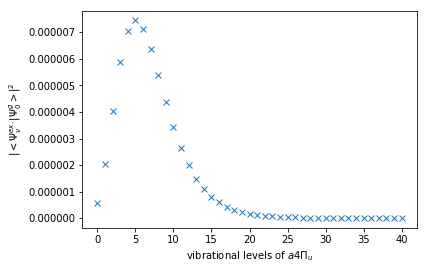

In [261]:
fc_l = FC(a_psi, g_psi, r)
plt.plot(np.abs(fc_l)**2, 'x')
plt.xlabel(r'vibrational levels of $a4\Pi_u$')
plt.ylabel(r'$|<\Psi^{ex.}_\nu|\Psi^{g}_0>|^2$')

In [266]:
def norm(psi1,fc,r):
    rn = len(psi1[0])
    psi_i = np.zeros(rn, dtype = 'complex_')
    for i in range(len(psi1)):
        psi_i += fc[i]*psi1[i]
    N_t = psi_i*np.conj(psi_i)*(r[1]-r[0])
    N = np.sqrt(N_t.sum())
    return np.real(N)

Once the given state is populated, the wave packet can be expressed as :

$\Psi_{packet}(r, t=0) = \sum_\nu fc_\nu |\Psi^{ex.}_\nu>$

The wave packet evolves along the given electronic state. So the time evolution can be expressed as :

$\Psi_{packet}(r, t) = \sum_\nu fc_\nu |\Psi^{ex.}_\nu>e^{-iE_\nu t}$

In [267]:
def psi_t(t,fc,psi1,en,r):
    rn = len(psi1[0])
    psi_i = np.zeros(rn, dtype = 'complex_')
    for i in range(len(psi1)):
        psi_i += fc[i]*psi1[i]*np.exp(-1j*en[i]*t)
    return psi_i/norm(psi1,fc,r)

In [268]:
t = np.linspace(0,2000,2001)
r_t = np.zeros((t.size,r.size))
rl = []

for i in range(t.size):
    psi = psi_t(t[i]*41,fc_l,a_psi,a_en,r)
    exp_r = np.conj(psi)*r*psi*(r[1]-r[0])
    val_r = np.conj(psi)*psi
    
    r_t[i,:] = np.abs(val_r)
    rl.append(np.real(exp_r).sum())  
    
r_t = r_t.transpose()
rl = np.asarray(rl)

(1.1, 2.0)

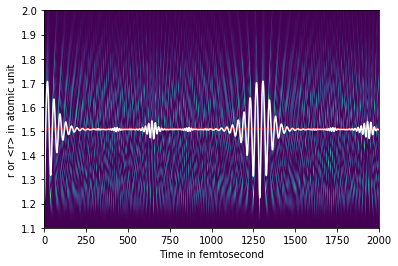

In [271]:
plt.imshow(r_t,aspect='auto', extent=(t.min(),t.max(),r.min()*au_aa,r.max()*au_aa), origin = 'lower')
plt.plot([t[0],t[-1]],[rl.mean()*au_aa,rl.mean()*au_aa],'r')
plt.plot(t,rl*au_aa,'w')
plt.xlabel('Time in femtosecond')
plt.ylabel('r or <r> in \AA')
plt.ylim([1.1,2.0])